Motorcycle dataset analysis, found at http://vincentarelbundock.github.io/Rdatasets/datasets.html under 'mcycle'

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import GPy
import numpy as np
from hetgp import HetGP
from svgp_multi import SVGPMulti
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
data_dir = './modx_data/'

def regression_metrics(y_true: np.array, y_pred: np.array):

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'Mean Squared Error (MSE)': np.float32(mse),
        'Mean Absolute Error (MAE)': np.float32(mae),
        'R-squared (R2)': np.float32(r2),
    }

    return metrics

In [3]:
restarts = 10
n_folds = 5
Ms = ['all'] #, 100]
#These are just starting values, lengthscales will also be randomized
f_rbf_len = 1 # 0.3
f_rbf_var = 0.5 # 0.5
g_rbf_len = 1 # 0.5
g_rbf_var = 0.5 # 0.5

# This is the log of mean of the posterior of the scale parameter, so we set it
# to be the log of roughly what we expect the scale parameter to be if it were
# constant

gauss_noise = 0.1
g_mean_val = None  # np.log(gauss_noise)
g_bias_var = None
f_bias_var = None # ['mean']
fixZ = True
preopt_scg_iters = 100
preopt_restarts = 3
scg_iters = 50
max_iters = 250
num_samples = 100000
gtol = 1e-5
ftol = 0
xtol = 0
starting_df = 4.0
optimize_df = True

fold = 0
seed = 0
np.random.seed(seed)

name = 'sim2.tsv'

In [4]:
from sklearn.model_selection import train_test_split

def read_tsv(path: str, name: str):
    return pd.read_csv(os.path.join(path, name), sep='\t')

def std_matrices(*mts):
    std_mts = []
    for mats in mts:
        if isinstance(mats, np.ndarray):  # Single matrix case
            mats = [mats]
        for mat in mats:
            min_vals = np.min(mat, axis=0)
            max_vals = np.max(mat, axis=0)
            std_mat = (mat - min_vals) / (max_vals - min_vals)
            std_mts.append(std_mat)
    return tuple(std_mts)

def holdout_split(
        df,
        test_size: float = 0.2,
        random_state: int = None,
    ):
    y = df.Y.values
    x = df.values[:, :-1]
    return train_test_split(
            x, y,
            test_size=test_size,
            random_state=random_state
        )

In [5]:
class Dataset(object):
    def __init__(self, Xtrain, Ytrain, Xtest, Ytest):
        self.Xtrain, self.Ytrain, self.Xtest, self.Ytest = Xtrain, Ytrain, Xtest, Ytest

def load_modx(seed):

    df = read_tsv(path=data_dir, name=name)    
    Y = df.Y.values
    X = df.values[:, :-1]
    Xtrain, Xtest, Ytrain, Ytest = std_matrices(
        holdout_split(
            df=read_tsv(path=data_dir, name=name),
            random_state=seed
            )
        )
    Ytrain = Ytrain[:, None]
    Ytest = Ytest[:, None]
    print("training shape: ", Xtrain.shape)
    print("test shape: ", Xtest.shape)
    print("All: ", X.shape)
    print(Xtrain.shape[0] + Xtest.shape[0] - X.shape[0])
    return Dataset(Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest), X, Y

dataset, X, Y = load_modx(seed)

Xtrain = dataset.Xtrain
Ytrain = dataset.Ytrain
Xtest = dataset.Xtest
Ytest = dataset.Ytest

training shape:  (240, 12)
test shape:  (60, 12)
All:  (300, 12)
0


In [6]:
def build_kernf(D, dataset, bias, f_rbf_len, f_rbf_var, seed, fold):
    kernf = GPy.kern.RBF(D, variance=f_rbf_var,
                         lengthscale=np.ones(D)*f_rbf_len, ARD=True,
                         name='kernf_rbf')
    kernf += GPy.kern.White(1, variance=0.001, name='f_white')
    if bias is not None:
        if bias == 'mean':
            f_bias_var = dataset.Ytrain.mean()
        else:
            f_bias_var = bias
            kernf += GPy.kern.Bias(1, variance=f_bias_var, name='f_bias')
    kernf.f_white.fix()
    kernf.name = 'kernf'
    return kernf

def build_kerng(D, g_bias, g_rbf_len, seed, fold):
    # Needs white or variance doesn't checkgrad!
    kerng = GPy.kern.RBF(D, variance=g_rbf_var,
                         lengthscale=np.ones(D)*g_rbf_len, ARD=True,
                         name='kerng_rbf')
    kerng += GPy.kern.White(1, variance=0.001, name='g_white')
    if g_bias is not None:
        kerng += GPy.kern.Bias(1, variance=g_bias, name='g_bias')
    kerng.g_white.fix()
    kerng.name = 'kerng'
    return kerng

from scipy.cluster.vq import kmeans as scipy_kmeans

def kmeans(dataset, k, seed):
    Z, _ = scipy_kmeans(dataset.Xtrain, k)
    return Z

def build_gauss_model(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold):
    D = dataset.Xtrain.shape[1]
    kernf = build_kernf(D, dataset, bias, f_rbf_len, f_rbf_var, seed, fold)
    m_gauss = GPy.models.SparseGPRegression(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z=Z.copy(), kernel=kernf)
    m_gauss.name='gauss_single'
    m_gauss.likelihood.variance[:] = gauss_noise
    return m_gauss

def preopt_gauss_scheme(m):
    m.kernf.constrain_positive()
    m.likelihood.variance.constrain_positive()
    if hasattr(m, 'Z'):
        m.Z.fix()
    m.optimize('bfgs', max_iters=preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    if hasattr(m, 'Z'):
        m.Z.unfix()
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    return m

def preopt_gauss(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold):
    m = build_gauss_model(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold)
    print("PreOptimizing gauss ", m)
    print(m.kernf.kernf_rbf.lengthscale)
    best_m = preopt_gauss_scheme(m)
    print("Found best gauss model")
    print(best_m)
    return best_m[:]

m1_opt = preopt_gauss(dataset, Xtrain.copy(), fixZ, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
m1 = build_gauss_model(dataset, Xtrain.copy(), fixZ, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
m1[:] = m1_opt

m1.Z.unfix()
m1.optimize('bfgs', max_iters=3000, messages=1)
print(m1)
print(m1.kernf.kernf_rbf.lengthscale)
mu_gauss, var_gauss = m1.predict(Xtest)

print(mu_gauss)
metrics = regression_metrics(y_true=Ytest, y_pred=mu_gauss)
print(f'train: {metrics}')


reconstraining parameters gauss_single.kernf


PreOptimizing gauss  
Name : gauss_single
Objective : 51.21017624901796
Number of Parameters : 2895
Number of Optimization Parameters : 2894
Updates : True
Parameters:
  gauss_single.                |      value  |  constraints  |  priors
  inducing_inputs              |  (240, 12)  |               |        
  kernf.kernf_rbf.variance     |        0.5  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |      (12,)  |      +ve      |        
  kernf.f_white.variance       |      0.001  |   +ve fixed   |        
  Gaussian_noise.variance      |        0.1  |      +ve      |        
  index  |  gauss_single.kernf.kernf_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                1.00000000  |      +ve      |        
  [1]    |                                1.00000000  |      +ve      |        
  [2]    |                                1.00000000  |      +ve      |        
  [3]    |                                1.00000000  |      +ve      |        
  [4] 

reconstraining parameters gauss_single.Gaussian_noise.variance


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s25  009  -2.290280e+02   3.621971e+03 
    06s55  042  -3.056613e+02   1.530431e+02 
    12s04  077  -3.405432e+02   2.496770e+01 
    16s18  102  -3.407833e+02   3.169021e+00 
Runtime:     16s18
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s14  001  -3.407833e+02   3.465739e+00 

 /home/rbarbano/projects/dev/ChainedGP/myenv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


    02s35  016  -3.408613e+02   2.130894e-01 
    07s75  051  -3.408625e+02   6.434973e-01 
    10s88  070  -3.408657e+02   3.378022e-01 
Runtime:     10s88
Optimization status: Converged

Found best gauss model

Name : gauss_single
Objective : -340.86566922465863
Number of Parameters : 2895
Number of Optimization Parameters : 2895
Updates : True
Parameters:
  gauss_single.                |                   value  |  constraints  |  priors
  inducing_inputs              |               (240, 12)  |               |        
  kernf.kernf_rbf.variance     |       45.09503036934604  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |                   (12,)  |      +ve      |        
  kernf.f_white.variance       |  5.562684646268137e-309  |      +ve      |        
  Gaussian_noise.variance      |    0.000323786945290136  |      +ve      |        
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s20  0008  -3.408658e+02   1.395515e-

In [26]:
print(m1.log_predictive_density(Xtest, Ytest).mean())
print(m1.kernf.kernf_rbf.lengthscale)

-0.36287782423458503
  index  |  gauss_single.kernf.kernf_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                1.05154797  |      +ve      |        
  [1]    |                                7.46872932  |      +ve      |        
  [2]    |                              804.80761633  |      +ve      |        
  [3]    |                              526.24241365  |      +ve      |        
  [4]    |                                1.08031904  |      +ve      |        
  [5]    |                              532.18647295  |      +ve      |        
  [6]    |                              620.39396361  |      +ve      |        
  [7]    |                                7.06621110  |      +ve      |        
  [8]    |                              904.76121361  |      +ve      |        
  [9]    |                              518.38983209  |      +ve      |        
  [10]   |                                6.82089836  |      +ve      |        
  [11]   |         

In [9]:
def random_multi_lengthscales(X_):
    normed_X = (X_.max(0) - X_.min(0))/X_.std(0)
    # print(normed_X)
    f_lengthscales = np.random.uniform(size=X_.shape[1])*(0.4/normed_X) + 0.001
    g_lengthscales = np.random.uniform(size=X_.shape[1])*(0.4/normed_X) + 0.001
    # print(f_lengthscales)
    return f_lengthscales, g_lengthscales

In [10]:
# Make the kernels : 
D = dataset.Xtrain.shape[1]
kernf = build_kernf(D, dataset, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
kerng = build_kerng(D, g_bias_var, g_rbf_len, seed, fold)
kern = [kernf, kerng]
mean_functions = [None, None]
likelihood = HetGP()

Z = dataset.Xtrain.copy()

# Make the model : 
m2 = SVGPMulti(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z.copy(), kern_list=kern,
                    likelihood=likelihood, mean_functions=mean_functions, name='multi_gauss')


def pretrain_multi(m, randomize=False):
    if randomize:
        f_lens, g_lens = random_multi_lengthscales(m.X.values)
        m.kernf.kernf_rbf.lengthscale[:] = f_lens
        m.kernf.kernf_rbf.variance[:] = f_rbf_var
        m.kerng.kerng_rbf.lengthscale[:] = g_lens
        m.kerng.kerng_rbf.variance[:] = g_rbf_var
    m.kernf.fix()
    m.kerng.fix()
    if hasattr(m, 'Z'):
        m.Z.fix()
    if hasattr(m, 'constmap'):
        m.constmap.fix()
    print(m)

    # Optimize model with fixed parameters to get latent functions in place
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    
    # Constrain all kernel parameters positive and reoptimize
    m.kernf.constrain_positive()
    m.kerng.constrain_positive()
    m.kernf.f_white.fix()
    m.kerng.g_white.fix()
    
    if hasattr(m, 'constmap'):
        m.constmap.unfix()

    # Continue with optimization with everything released
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)

    return m

m2 = pretrain_multi(m2)


Name : multi_gauss
Objective : 7623.022000324801
Number of Parameters : 61228
Number of Optimization Parameters : 58320
Updates : True
Parameters:
  multi_gauss.                 |       value  |  constraints  |  priors
  inducing_inputs              |   (240, 12)  |     fixed     |        
  q_u_means                    |    (240, 2)  |               |        
  qf_u_chols                   |  (28920, 2)  |               |        
  kernf.kernf_rbf.variance     |         0.5  |   +ve fixed   |        
  kernf.kernf_rbf.lengthscale  |       (12,)  |   +ve fixed   |        
  kernf.f_white.variance       |       0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |         0.5  |   +ve fixed   |        
  kerng.kerng_rbf.lengthscale  |       (12,)  |   +ve fixed   |        
  kerng.g_white.variance       |       0.001  |   +ve fixed   |        
Running Scaled Conjugate Gradients Code:
  runtime   i     f              |g|        
    00s18  005   2.469865e+03   3.427449e+05 


reconstraining parameters multi_gauss.kernf
reconstraining parameters multi_gauss.kerng



Runtime:     15s64
Optimization status: maxiter exceeded

Running Scaled Conjugate Gradients Code:
  runtime   i     f              |g|        
    00s11  001   3.548408e+01   7.339953e+01 
    02s21  023  -3.500383e+01   1.011997e+04 
    04s39  043  -4.783137e+01   5.140690e+04 
    13s88  146  -1.012918e+02   9.882919e+02 
    30s76  302  -1.481911e+02   8.106327e+02 
Runtime:     30s76
Optimization status: maxiter exceeded

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s15  000  -1.481911e+02   9.494269e+02 
    02s26  018  -1.512348e+02   3.580820e+02 
    09s67  079  -1.816008e+02   1.526087e+02 
    30s42  238  -2.002423e+02   8.439944e+01 
    50s51  381  -2.059785e+02   1.414499e+01 
 01m08s77  502  -2.085446e+02   2.011908e+01 
Runtime:  01m08s77
Optimization status: Maximum number of f evaluations reached



In [11]:

m2.Z.unfix()
m2.optimize('bfgs', max_iters=100, messages=1)
print(m2)
mu_multi_gauss, _ = m2._raw_predict(Xtest, 0)
var_multi_gauss, _ = m2._raw_predict(Xtest, 1)
print(mu_multi_gauss)
metrics = regression_metrics(y_true=Ytest, y_pred=mu_multi_gauss)
print(f'train: {metrics}')

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    03s24  011  -2.088977e+02   4.417058e+02 
    11s08  045  -2.107318e+02   8.718107e+01 
    23s68  102  -2.115608e+02   2.330801e+02 
Runtime:     23s68
Optimization status: Maximum number of f evaluations reached


Name : multi_gauss
Objective : -211.56077992172027
Number of Parameters : 61228
Number of Optimization Parameters : 61226
Updates : True
Parameters:
  multi_gauss.                 |               value  |  constraints  |  priors
  inducing_inputs              |           (240, 12)  |               |        
  q_u_means                    |            (240, 2)  |               |        
  qf_u_chols                   |          (28920, 2)  |               |        
  kernf.kernf_rbf.variance     |  0.6969623585716113  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |               (12,)  |      +ve      |        
  kernf.f_white.variance       |               0.001  |   +v

In [12]:
print(m2.kernf.kernf_rbf.lengthscale)
print(m2.kerng.kerng_rbf.lengthscale)

  index  |  multi_gauss.kernf.kernf_rbf.lengthscale  |  constraints  |  priors
  [0]    |                               1.46490385  |      +ve      |        
  [1]    |                              10.07374433  |      +ve      |        
  [2]    |                              21.11842779  |      +ve      |        
  [3]    |                              20.21164497  |      +ve      |        
  [4]    |                               0.95236993  |      +ve      |        
  [5]    |                              22.39178498  |      +ve      |        
  [6]    |                              19.69921597  |      +ve      |        
  [7]    |                               1.65109865  |      +ve      |        
  [8]    |                              20.81272575  |      +ve      |        
  [9]    |                              21.63001540  |      +ve      |        
  [10]   |                               1.56246943  |      +ve      |        
  [11]   |                               0.84200775 

In [13]:
m2.log_predictive_density(Xtest, Ytest).mean()

0.813688182440948

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms(vector1, vector2, bins=100, alpha=0.65, label1='abs-error', label2='std'):
    # Plot histograms for the two vectors
    plt.hist(vector1, bins=bins, alpha=alpha, label=label1)
    plt.hist(vector2, bins=bins, alpha=alpha, label=label2)
    
    # Adding legend to differentiate the two vectors
    plt.legend(loc='upper right')
    
    # Labels and title for clarity
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.yscale('log')
    plt.show()

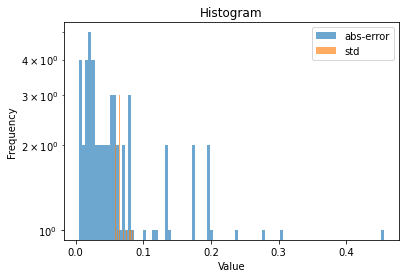

In [23]:
m2.log_predictive_density(Xtest, Ytest).mean()
abs_error = np.abs(mu_multi_gauss - Ytest)
std = np.sqrt(np.exp(var_multi_gauss))
plot_histograms(abs_error, std)